# Foreword

This notebook will be used for the computer vision part, due to local computer performances.
# Goal
In this notebook, I'll load the images fetched in my local notebook and saved as .csv file. This file must be named **P6_04_images.csv**  and uploaded on the 3rd code cell.

I'll then process the images, detect features with ORB and VGG16 to create a classification model for our images.


# Code
## Imports


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io

from tqdm import tqdm_notebook as tqdm
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
import requests

from PIL import Image

import cv2
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.cluster import MiniBatchKMeans

from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array, image
from keras.applications.vgg16 import preprocess_input

from keras.applications.vgg16 import VGG16

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation
from keras.models import clone_model

import requests
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import gc, os
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings('ignore')


In [3]:
%%capture
tqdm().pandas()

## Image upload

In [4]:
from google.colab import files

uploaded = files.upload()

df = pd.read_csv(io.StringIO(uploaded['P6_04_images.csv'].decode('utf-8')))
df.shape

Saving P6_04_images.csv to P6_04_images.csv


(300, 2)

### Folders creation and image fetching

In [7]:
import urllib.request
if not os.path.exists('images'):
    os.makedirs('images')
if not os.path.exists('images_gray'):
    os.makedirs('images_gray')
if not os.path.exists('images_vgg16'):
    os.makedirs('images_vgg16')
display("Récupération des images")
with tqdm(total=len(df)) as pbar:
    for index, pic in enumerate(df.photos):
        # display(pic[2:-12])
        img_data = requests.get(pic).content
        with open('images/{}.jpg'.format(index), 'wb') as handler:
          handler.write(img_data)
        pbar.update(1)


'Récupération des images'

## Test on one image
### Image visualization

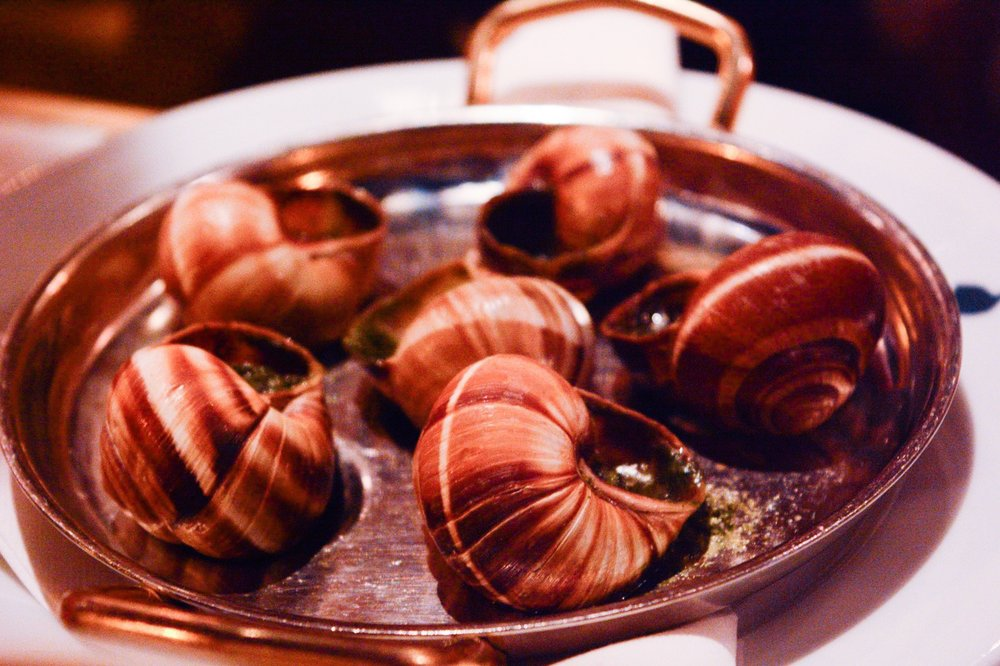

In [8]:
from google.colab.patches import cv2_imshow
if os.path.isfile("images/0.jpg"):
    img = cv2.imread('images/0.jpg', cv2.IMREAD_UNCHANGED)
    cv2_imshow(img)
else:
    print ("The file images/0.jpg does not exist.")


### Orginal histogram

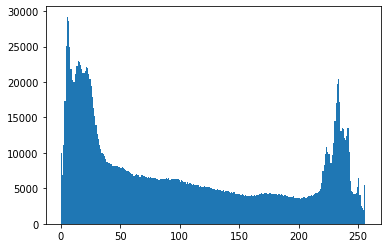

In [9]:
img_test = cv2.imread('images/0.jpg')
plt.hist(img_test.ravel(),256,[0,256]);


### Grayscale conversion

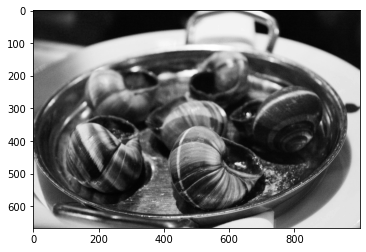

In [10]:
img_test_gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
plt.imshow(img_test_gray, cmap='gray')

### Histogram equalization

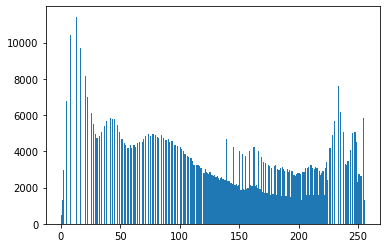

In [11]:
equ = cv2.equalizeHist(img_test_gray)
plt.hist(equ.ravel(),256,[0,256]); 

### Getting image key features with ORB

In [16]:
orb = cv2.ORB_create(nfeatures = 40)

def extract_descriptors(path):
    features_list = []
    preprocessed_image = []
    display("Récupération des features")
    with tqdm(total=len(os.listdir(path))) as pbar:
        for file in os.listdir(path):
            file = path +'/'+ file
            img = cv2.imread(file)
            plt.imshow(img)
            kpts, des = orb.detectAndCompute(img, None)
            if des is not None :
                features_list.append(des) 
         
            pbar.update(1)
    
    return features_list 



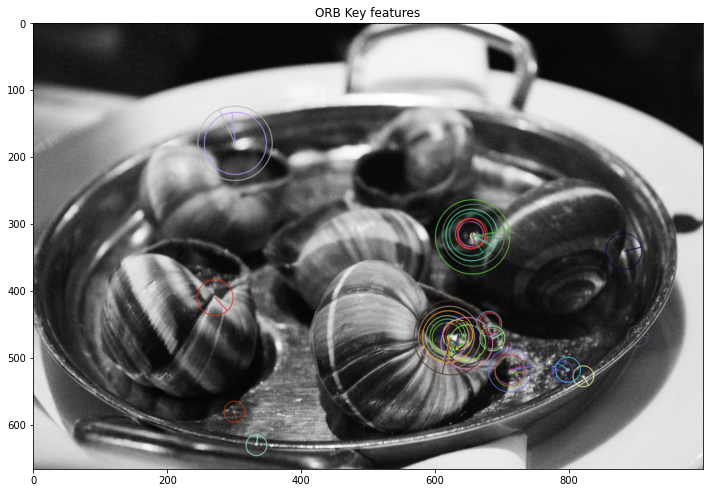

In [24]:
kp, des = orb.detectAndCompute(img_test_gray, None)
keypoints = cv2.drawKeypoints(img_test_gray, 
                                           kp, 
                                           img_test_gray, 
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
plt.figure(figsize=(12, 12))
plt.title('ORB Key features')
plt.imshow(keypoints); 
plt.show()

## Process creation

In [25]:
def image_processing(path, width=500, height=500):
    
    img = cv2.imread(path)
    # resize
    img = cv2.resize(img, (width, height), Image.BILINEAR)
    # De-noise
    img =  cv2.fastNlMeansDenoisingColored(img)#img.filter(ImageFilter.MinFilter())
    # convert to gray
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # equalize histogram
    img_gray = cv2.equalizeHist(img_gray)
    filename, ext = path.split(".")
    #save
    cv2.imwrite('images_gray/{}_gray.{}'.format(filename.split('/')[1], ext), img_gray) 
    

img_amt = len(os.listdir('images/'))
display("Traitement des images")
with tqdm(total=img_amt) as pbar:
    for img in os.listdir('images/'):
        image_processing('images/{}'.format(img))
        pbar.update(1)

'Traitement des images'

### Processing all images

'Récupération des features'

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

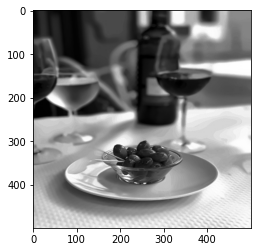

In [26]:
clusters = 3
feature_list, processed_img = extract_descriptors('images_gray')

kmeans = KMeans(n_clusters = clusters, n_init=10, init='random')
X = [item for sublist in feature_list for item in sublist]
kmeans.fit(X)


In [27]:
import math as m

documentsPerFeature=[0] * 3

alla=[]
for i in feature_list:
    clusters=[]
    for u in i:
        cluster=kmeans.predict([u])  
        clusters.append(cluster[0])
        
    nums=pd.Series(clusters).value_counts()
    tf=nums.apply(lambda a:a/nums.sum())
    alla.append(tf.to_dict())
#tf for each feature in the document

for i in alla:
    for k in i:
        documentsPerFeature[k-1]=documentsPerFeature[k-1]+1
fr= pd.DataFrame(columns= range(1,201))
for i in alla:
    row=[0]*200
    totalWords=0
    for k in i:
        idf=m.log(len(alla)/documentsPerFeature[k-1])
        res=i[k]*idf
        row[k]=res
    fr=fr.append(pd.Series(row, range(1,201)),ignore_index=True )  
fr       
    

1    2    3    4    5    6    7    ...  194  195  196  197  198  199  200
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
295  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
296  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
297  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
298  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
299  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[300 rows x 200 columns]

### Dimension reduction
#### PCA

In [28]:


scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=0.95, random_state=0)
pca.fit(X)


PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

#### T-SNE

In [30]:
data_pca = pca.transform(X)
tsne = TSNE(n_components=2, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(data_pca.copy())

col = ["tsne_" + str(n + 1) for n in range(tsne_results.shape[1])]
data_tsne = pd.DataFrame(tsne_results, columns=col)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.044s...
[t-SNE] Computed neighbors for 12000 samples in 8.155s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 2.578366
[t-SNE] KL divergence

### Quick Kmeans hypertuning

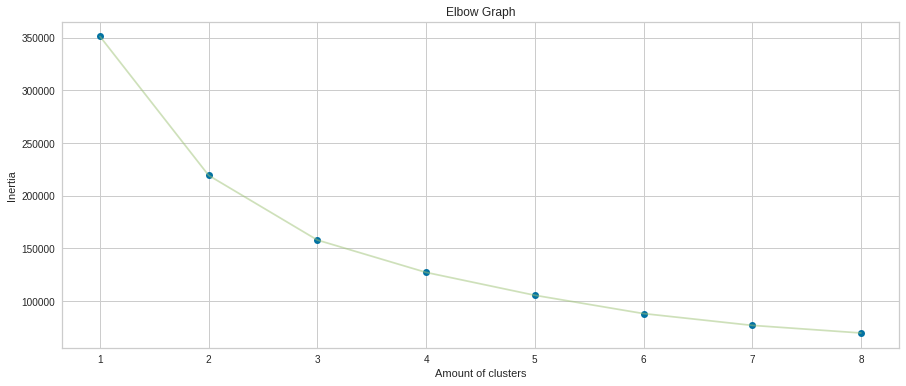

In [31]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

inertia = []
kmeans = []
for i in range(2, 10):
    model = KMeans(n_clusters=i, random_state=0)
    model.fit(tsne_results)
    inertia.append(model.inertia_)
    kmeans.append(model)
    
plt.figure(1, figsize=(15, 6))
plt.plot(np.arange(1, 9), inertia, 'o')
plt.plot(np.arange(1, 9), inertia, '-', alpha=0.5)
plt.xlabel('Amount of clusters'), plt.ylabel('Inertia')
plt.title('Elbow Graph')
plt.show()

Silhouette score with T-SNE dataset
For n_clusters = 2, average silhouette score is 0.3416522741317749
For n_clusters = 3, average silhouette score is 0.37240633368492126
For n_clusters = 4, average silhouette score is 0.3618294298648834
For n_clusters = 5, average silhouette score is 0.3417040705680847
Best score: 0.37240633368492126 (3 clusters)


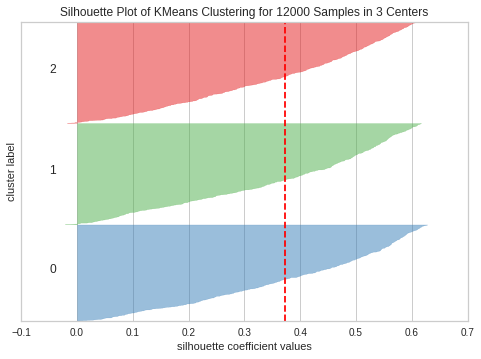

In [32]:
print("Silhouette score with T-SNE dataset")
from sklearn.metrics import silhouette_score
n_clusters = range(2, 6)

X = tsne_results.copy()
max_score = 0
opt_clusters = 0
for i in n_clusters:
    model = KMeans(n_clusters=i, random_state=0)
    cluster_labels = model.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    if silhouette_avg > max_score:
        max_score = silhouette_avg
        opt_clusters = i
    print("For n_clusters = {}, average silhouette score is {}".format(
        i, silhouette_avg))
print("Best score: {} ({} clusters)".format(max_score, opt_clusters))
model = KMeans(n_clusters=opt_clusters, random_state=0)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)
visualizer.poof()
pass;

### Cluster visualization

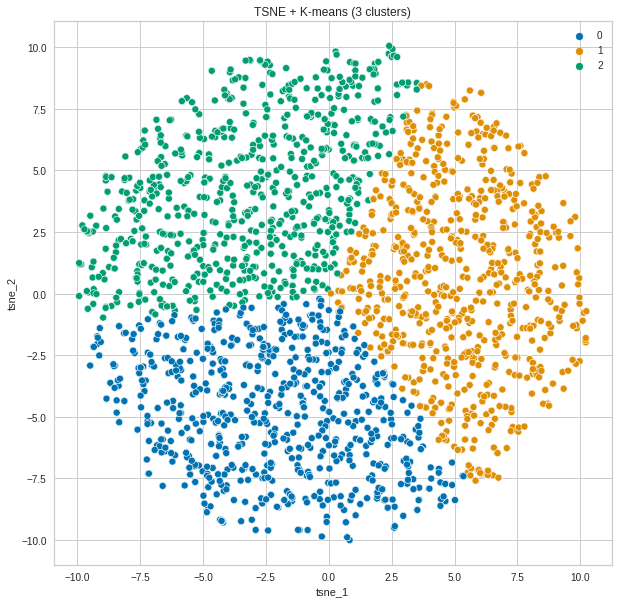

In [33]:
kmeans = KMeans(n_clusters=opt_clusters, n_jobs=-1, random_state=0)
kmeans.fit(tsne_results)            
labels =  kmeans.labels_
plt.figure(figsize=(10, 10))
plt.title('TSNE + K-means ({} clusters)'.format(opt_clusters))
labels = kmeans.labels_

sns.scatterplot(data=data_tsne,
                x='tsne_1',
                y='tsne_2',
                hue=labels,
                palette='colorblind',
                cmap='RdBu')
plt.show()

## Transfer Learning VGG16

In [34]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 1s 0us/step


### Feeding the model

In [35]:
def image_processing_vgg16(path):
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

img_amt = len(os.listdir('images/'))
display("Traitement des images")
vgg16_feature_list = []
with tqdm(total=img_amt) as pbar:
    for path in os.listdir('images/'):
        img = image_processing_vgg16("images/"+path)
        vgg16_feature = model.predict(img)
        vgg16_feature_np = np.array(vgg16_feature)
        vgg16_feature_list.append(vgg16_feature_np.flatten())
        pbar.update(1)

'Traitement des images'

In [36]:
features = pd.DataFrame(vgg16_feature_list)
features.shape

(300, 25088)

### Dimension reduction

In [39]:
pca = PCA(n_components=0.95, random_state=0)
pca.fit(features)
data_pca = pca.transform(features)
print(data_pca.shape)

(300, 43)


In [40]:

tsne = TSNE(n_components=2, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(data_pca.copy())

col = ["tsne_" + str(n + 1) for n in range(tsne_results.shape[1])]
data_tsne = pd.DataFrame(tsne_results, columns=col)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.001s...
[t-SNE] Computed neighbors for 300 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 1089.238553
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.287231
[t-SNE] KL divergence after 300 iterations: 0.615246


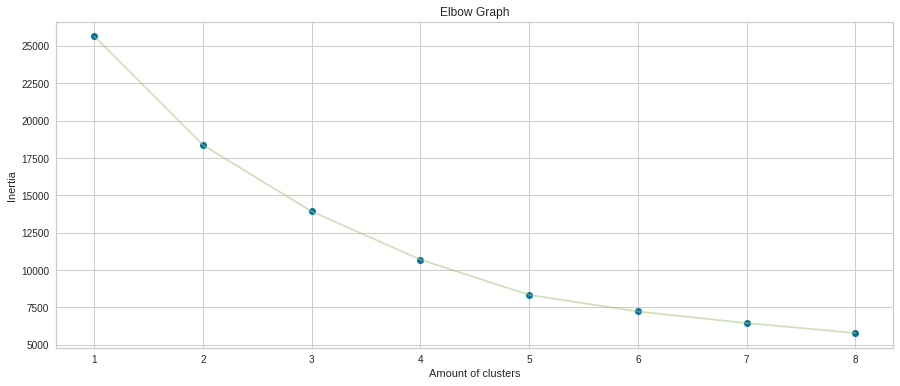

In [41]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

inertia = []
kmeans = []
for i in range(2, 10):
    model = KMeans(n_clusters=i, random_state=0)
    model.fit(tsne_results)
    inertia.append(model.inertia_)
    kmeans.append(model)
    
plt.figure(1, figsize=(15, 6))
plt.plot(np.arange(1, 9), inertia, 'o')
plt.plot(np.arange(1, 9), inertia, '-', alpha=0.5)
plt.xlabel('Amount of clusters'), plt.ylabel('Inertia')
plt.title('Elbow Graph')
plt.show()

In [42]:
print("Silhouette score with T-SNE dataset")
from sklearn.metrics import silhouette_score
n_clusters = range(2, 6)

X = tsne_results.copy()
max_score = 0
opt_clusters = 0
for i in n_clusters:
    model = KMeans(n_clusters=i, random_state=0)
    cluster_labels = model.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    if silhouette_avg > max_score:
        max_score = silhouette_avg
        opt_clusters = i
    print("For n_clusters = {}, average silhouette score is {}".format(
        i, silhouette_avg))
print("Best score: {} ({} clusters)".format(max_score, opt_clusters))


Silhouette score with T-SNE dataset
For n_clusters = 2, average silhouette score is 0.33612796664237976
For n_clusters = 3, average silhouette score is 0.3380788564682007
For n_clusters = 4, average silhouette score is 0.3432728946208954
For n_clusters = 5, average silhouette score is 0.3725213408470154
Best score: 0.3725213408470154 (5 clusters)


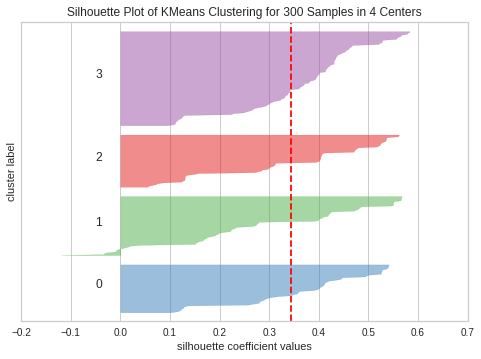

In [43]:
model = KMeans(n_clusters=4, random_state=0)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X)
visualizer.poof()
pass;

In [44]:
kmeans = KMeans(n_clusters=4, n_jobs=-1, random_state=0)
kmeans.fit(tsne_results)            
labels =  kmeans.labels_


### Classification clustering

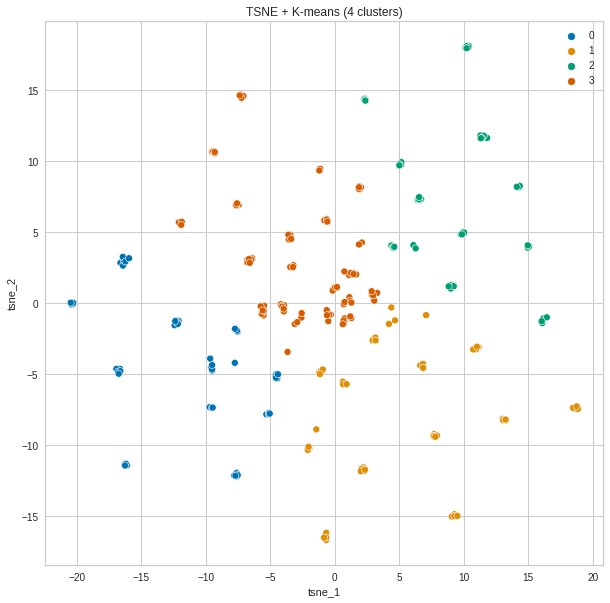

In [45]:
col = ["tsne_" + str(n + 1) for n in range(tsne_results.shape[1])]
data_tsne = pd.DataFrame(tsne_results, columns=col)
plt.figure(figsize=(10, 10))
plt.title('TSNE + K-means (4 clusters)')
labels = kmeans.labels_
sns.scatterplot(data=data_tsne,
                x='tsne_1',
                y='tsne_2',
                hue=labels,
                palette='colorblind',
                cmap='RdBu')
plt.show()

## Testing the model
### Uploading train set

In [ ]:
from google.colab import files
import zipfile
#trainset
uploaded = files.upload()



In [ ]:
!unzip '/content/drive/MyDrive/train_test.zip'
pass;

In [ ]:
!ls

### Category creation

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="train",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="test", target_size=(224,224))

In [ ]:
vggmodel = VGG16(weights='imagenet', include_top=True)

In [ ]:
from keras.models import Model
for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable = False
X= vggmodel.layers[-2].output
predictions = Dense(2, activation="sigmoid")(X)
model_final = Model(vggmodel.input, predictions)

In [ ]:
from keras import optimizers

model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model_final.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
model_final.fit_generator(generator= traindata, steps_per_epoch= 2, epochs= 30,
                          validation_data= testdata, validation_steps=1, callbacks=[checkpoint,early])
model_final.save("vgg16_1.h5")

### Uploading validation set

In [ ]:
#validation set
uploaded = files.upload()


In [ ]:
!unzip 'validation.zip'

In [ ]:
!ls validation



In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

import random
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input, decode_predictions
saved_model = load_model("vgg16_1.h5")

fig, axs = plt.subplots(4, 4, figsize=(15, 17))
plt.grid(False)

for index, (ax, i) in enumerate(zip(axs.ravel(), os.listdir('validation/'))):
  img = image.load_img("validation/"+i,target_size=(224,224))
  img = np.asarray(img)
  ax.grid(False)
  ax.imshow(img)
  img = np.expand_dims(img, axis=0)
  output = saved_model.predict(img)
  display(output)
  if output[0][0] > output[0][1]:
      ax.title.set_text("Food: {}%".format(round(output[0][0]*100)))
  else:
      ax.title.set_text("Not Food: {}%".format(round(output[0][1]*100)))


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)